In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# 1000 Genomes analysis
The tree sequence files for 1kg are available [here](https://zenodo.org/record/3051855). The other metadata files are part of the public 1kg release.

In [2]:
import os
import tskit
import numpy as np
import xsmc
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
from xsmc.supporting.kde_ne import kde_ne
from xsmc.supporting.plotting import *
import logging
import os


logging.getLogger("xsmc").setLevel(logging.INFO)
PAPER_ROOT = os.path.expanduser(os.environ.get("PAPER_ROOT", "."))

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(1)


def seed():
    return np.random.randint(1, np.iinfo(np.int32).max)

<IPython.core.display.Javascript object>

In [4]:
full_chroms = [tskit.load(f"/scratch/1kg/trees/1kg_chr{i}.trees") for i in range(1, 23)]
# chr1 = chr1.delete_intervals([[0, 16e6]], simplify=False).trim()

<IPython.core.display.Javascript object>

## Accessibility masking
The 1kg tree sequences feature some trees that span huge intervals. These represent centromeres, telomeres, or other inaccessible regions. To our method they appear as huge tracts of IBD, leading to downward bias in the size history estimates. To properly correct for this we should use the 1kg accessibility masks, but here I adopt the simpler approach of heuristically chopping out trees that span large segments (>1Mb).

In [5]:
long_spans = {}
for i, chrom in enumerate(full_chroms, 1):
    long_spans[i] = [t.interval for t in chrom.trees() if np.diff(t.interval) > 1e6]
long_spans

{1: [Interval(left=121347335.0, right=142643153.0)],
 2: [Interval(left=90490322.0, right=91634056.0),
  Interval(left=92102205.0, right=95333904.0)],
 3: [Interval(left=90291128.0, right=93527692.0)],
 4: [Interval(left=49629442.0, right=52700457.0)],
 5: [Interval(left=46118241.0, right=49571959.0)],
 6: [Interval(left=58665913.0, right=61967504.0)],
 7: [Interval(left=57669630.0, right=62465883.0)],
 8: [Interval(left=43529404.0, right=47458633.0)],
 9: [Interval(left=47309856.0, right=65510886.0)],
 10: [Interval(left=39043557.0, right=42746452.0)],
 11: [Interval(left=50381334.0, right=51436554.0),
  Interval(left=51510699.0, right=55254669.0)],
 12: [Interval(left=34340941.0, right=38610698.0)],
 13: [Interval(left=0.0, right=19037838.0)],
 14: [Interval(left=0.0, right=19083007.0)],
 15: [Interval(left=0.0, right=20253797.0)],
 16: [Interval(left=35146682.0, right=46554124.0)],
 17: [Interval(left=22155426.0, right=25392232.0)],
 18: [Interval(left=15357425.0, right=18535477.0)]

<IPython.core.display.Javascript object>

Now we simply chop these intervals out. This technically allows IBD tracts to span these gaps during inference, but the effect should be minimal.

In [6]:
chroms = [
    chrom.delete_intervals(long_spans[i], simplify=False).trim()
    for i, chrom in enumerate(full_chroms, 1)
]

<IPython.core.display.Javascript object>

In [7]:
# 1kg metadata

with open("/scratch/1kg/integrated_call_samples_v3.20130502.ALL.panel", "rt") as f:
    next(f)
    rows = (line.strip().split("\t") for line in f)
    sample_map = {sample_id: (pop, superpop) for sample_id, pop, superpop, _ in rows}

<IPython.core.display.Javascript object>

In [8]:
# map each 1kg sample id ts nodes
import json

samples_to_nodes = {
    json.loads(ind.metadata)["individual_id"]: ind.nodes
    for ind in chroms[0].individuals()
}

<IPython.core.display.Javascript object>

In [9]:
superpops = {}
for sample_id, (p, sp) in sample_map.items():
    superpops.setdefault(sp, [])
    superpops[sp].append(sample_id)

<IPython.core.display.Javascript object>

In [10]:
K = 20  # number of samples to take from each superpopulation
mu = 1.4e-8  # assumed mutation rate for humans


def process_samples(sample_dict, w, rho_over_theta):
    sampled_heights = {}
    lines = {}
    for sp in sample_dict:
        print(sp, flush=True)
        xs = []
        for sample_id in sample_dict[sp][:K]:
            print("\t%s" % sample_id)
            f, p = samples_to_nodes[sample_id]
            for data in chroms:
                xs.append(
                    xsmc.XSMC(
                        data, focal=f, panel=[p], w=w, rho_over_theta=rho_over_theta
                    )
                )
        with ThreadPoolExecutor(24) as p:
            futs = [
                p.submit(
                    x.sample_heights,
                    j=100,
                    k=int(x.ts.get_sequence_length() / 50_000),
                    seed=seed(),
                )
                for x in xs
            ]

        sampled_heights[sp] = np.concatenate(
            [f.result() * 2 * x.theta / (4 * mu) for f, x in zip(futs, xs)], axis=1
        )  # rescale each sampled path by 2N0 so that segment heights are in generations
    return sampled_heights

<IPython.core.display.Javascript object>

## Time to process 1 whole genome

In [11]:
%%time
_ = process_samples({'test': ['NA12878']}, w=500, rho_over_theta=1.)

test
	NA12878
CPU times: user 7min 36s, sys: 743 ms, total: 7min 37s
Wall time: 37.8 s


<IPython.core.display.Javascript object>

## Main event
Run pipeline for all 1kg samples split into 5 superpopulations

In [12]:
def make_plot(sampled_heights, g, name):
    fig, ax = plt.subplots(figsize=(8, 5))
    x0 = np.geomspace(1e2, 1e6, 1000)
    for sp, col in zip(sampled_heights, TABLEAU):
        lines = []
        A = np.array(sampled_heights[sp])
        with ProcessPoolExecutor() as p:
            futs = [p.submit(kde_ne, a.reshape(-1)) for a in A]
            for f in as_completed(futs):
                x, y = f.result()
                lines.append((x * g, y / 2))  # rescale to years, plot diploid Ne
        plot_summary(ax, lines, x0, color=col, label=sp)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(loc="lower right")
    ax.set_xlabel(r"Years ($\mu=1.4\times 10^{-8}, g=%d$)" % g)
    ax.set_ylabel("Effective Population Size ($N_e$)")
    fig.tight_layout()
    fig.savefig(os.path.join(PAPER_ROOT, "figures", "xsmc_1kg_%s.pdf" % name))
    return fig

<IPython.core.display.Javascript object>

In [13]:
%%time
sampled_heights = process_samples(superpops, w=500, rho_over_theta=1.)

EUR
	HG00096
	HG00097
	HG00099
	HG00100
	HG00101
	HG00102
	HG00103
	HG00105
	HG00106
	HG00107
	HG00108
	HG00109
	HG00110
	HG00111
	HG00112
	HG00113
	HG00114
	HG00115
	HG00116
	HG00117
EAS
	HG00403
	HG00404
	HG00406
	HG00407
	HG00409
	HG00410
	HG00419
	HG00421
	HG00422
	HG00428
	HG00436
	HG00437
	HG00442
	HG00443
	HG00445
	HG00446
	HG00448
	HG00449
	HG00451
	HG00452
AMR
	HG00551
	HG00553
	HG00554
	HG00637
	HG00638
	HG00640
	HG00641
	HG00731
	HG00732
	HG00734
	HG00736
	HG00737
	HG00739
	HG00740
	HG00742
	HG00743
	HG01047
	HG01048
	HG01049
	HG01051
SAS
	HG01583
	HG01586
	HG01589
	HG01593
	HG02490
	HG02491
	HG02493
	HG02494
	HG02597
	HG02600
	HG02601
	HG02603
	HG02604
	HG02648
	HG02649
	HG02651
	HG02652
	HG02654
	HG02655
	HG02657
AFR
	HG01879
	HG01880
	HG01882
	HG01883
	HG01885
	HG01886
	HG01889
	HG01890
	HG01894
	HG01896
	HG01912
	HG01914
	HG01915
	HG01956
	HG01958
	HG01985
	HG01986
	HG01988
	HG01989
	HG01990
CPU times: user 15h 50min 50s, sys: 32.1 s, total: 15h 51min 22s
Wall time: 41mi

<IPython.core.display.Javascript object>

/home/terhorst/opt/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
2020-09-21 16:03:00,023 WARNING matplotlib.font_manager MainThread findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2020-09-21 16:03:00,225 WARNING matplotlib.font_manager MainThread findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


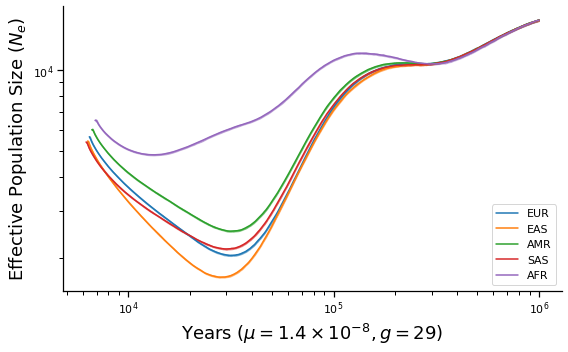

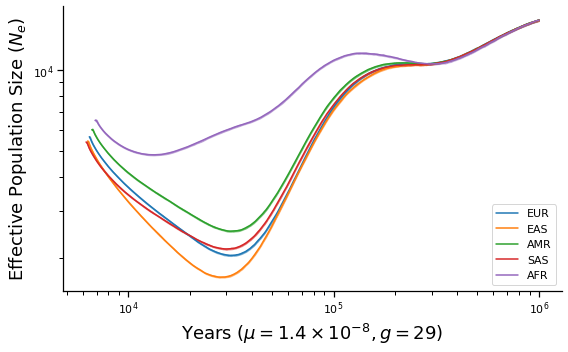

<IPython.core.display.Javascript object>

In [14]:
make_plot(sampled_heights, 29, "final")